### Проект e-commerce.
Продакт-менеджер попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?
2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 
3. По каждому товару определить, в какой день недели товар чаще всего покупается. 
4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 
5. Используя pandas, провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц. 
6. Используя python, построить RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можно выбрать следующие метрики:   
R - время от последней покупки пользователя до текущей даты,  
F - суммарное количество покупок у пользователя за всё время,   
M - сумма покупок за всё время.   
Для каждого RFM-сегмента построить границы метрик recency, frequency и monetary для интерпретации этих кластеров.   
Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. 

Для решения задачи необходимо провести предварительное исследование данных и сформулировать, что должно считаться покупкой. 

Файлы:
#### olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
customer_id — позаказный идентификатор пользователя  
customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)  
customer_zip_code_prefix —  почтовый индекс пользователя  
customer_city —  город доставки пользователя  
customer_state —  штат доставки пользователя  
#### olist_orders_dataset.csv —  таблица заказов
order_id —  уникальный идентификатор заказа (номер чека)  
customer_id —  позаказный идентификатор пользователя  
order_status —  статус заказа  
order_purchase_timestamp —  время создания заказа  
order_approved_at —  время подтверждения оплаты заказа  
order_delivered_carrier_date —  время передачи заказа в логистическую службу  
order_delivered_customer_date —  время доставки заказа  
order_estimated_delivery_date —  обещанная дата доставки  
#### olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
order_id —  уникальный идентификатор заказа (номер чека)  
order_item_id —  идентификатор товара внутри одного заказа  
product_id —  ид товара (аналог штрихкода)  
seller_id — ид производителя товара  
shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике  
price —  цена за единицу товара  
freight_value —  вес товара  

Уникальные статусы заказов в таблице olist_orders_dataset:  
created —  создан  
approved —  подтверждён  
invoiced —  выставлен счёт  
processing —  в процессе сборки заказа  
shipped —  отгружен со склада  
delivered —  доставлен пользователю  
unavailable —  недоступен  
canceled —  отменён  

### План работы
 1.  <a href="#Загрузка данных и ознакомление, подготовка объединенных данных">Загрузка данных и ознакомление, подготовка объединенных данных</a>   
 2.  <a href="#Исследовательский анализ, определение понятия Покупка">Исследовательский анализ, определение понятия "Покупка"</a>     
2.1. <a href="#Пользователи, которые совершили покупку только один раз">Пользователи, которые совершили покупку только один раз</a>  
2.2 <a href="#Количество заказов в месяц, которое в среднем не доставляется по разным причинам">Количество заказов в месяц, которое в среднем не доставляется по разным причинам</a>  
     2.3 <a href="#В какой день недели чаще всего покупается определенный товар">В какой день недели чаще всего покупается определенный товар</a>  
     2.4 <a href="#Среднее количество покупок в неделю у каждого из пользователей (по месяцам)">Среднее количество покупок в неделю у каждого из пользователей (по месяцам)</a>  
 3.  <a href="#Когортный анализ пользователей">Когортный анализ пользователей</a>  
 4. <a href="#RFM-сегментация пользователей">RFM-сегментация пользователей</a>  
 5. <a href="#Выводы">Выводы</a>

#### 1.  Загрузка данных и ознакомление, подготовка объединенных данных  <a name ="Загрузка данных и ознакомление, подготовка объединенных данных"></a>

In [372]:
import pandas as pd
import requests 
from urllib.parse import urlencode 
from datetime import datetime as dt
from datetime import date
from datetime import timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

In [3]:
sns.set(
    style="whitegrid",
    palette='pastel',
        )

Используя api, считаем файлы по ссылкам на Яндекс диск и изучим имеющиеся данные.

In [4]:
def get_df_by_yandex_link(yandex_link):
    base_url     = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key   = yandex_link    
    final_url    = base_url + urlencode(dict(public_key=public_key)) 
    response     = requests.get(final_url) 
    download_url = response.json()['href'] 
    return pd.read_csv(download_url)    

In [5]:
df_customers   = get_df_by_yandex_link('https://disk.yandex.ru/d/QXrVDUoQvFhIcg') #таблица с уникальными id пользователей
df_order_items = get_df_by_yandex_link('https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg') #товарные позиции, входящие в заказы
df_orders      = get_df_by_yandex_link('https://disk.yandex.ru/d/0zWmh1bYP6REbw') #таблица заказов

Посмотрим на содержание файлов и тип данных.

In [480]:
dfs = [df_customers, df_orders, df_order_items]

In [481]:
for df in dfs:
    print (df.columns.values)

['customer_id' 'customer_unique_id' 'customer_zip_code_prefix'
 'customer_city' 'customer_state']
['order_id' 'customer_id' 'order_status' 'order_purchase_timestamp'
 'order_approved_at' 'order_delivered_carrier_date'
 'order_delivered_customer_date' 'order_estimated_delivery_date']
['order_id' 'order_item_id' 'product_id' 'seller_id' 'shipping_limit_date'
 'price' 'freight_value']


In [482]:
for df in dfs:
    print (df.dtypes)

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object
order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object
order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object


Приведем столбцы с датами к формату datetime64.

In [483]:
df_order_items['shipping_limit_date'] = pd.to_datetime(df_order_items['shipping_limit_date'])

date_columns = ['order_purchase_timestamp',
                'order_approved_at', 
                'order_delivered_carrier_date',
                'order_delivered_customer_date',
                'order_estimated_delivery_date']
df_orders[date_columns] = df_orders[date_columns].applymap(pd.to_datetime)

Убедимся, что тип данных корректно изменился.

In [484]:
for df in dfs:
    print (df.dtypes)

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object
order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object
order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object


Проанализируем имеющиеся данные о заказах:
Выведем общее количество уникальных значений по каждому столбцу. 
Мы видим, что всего было оформлено 99.4 тыс. заказов (order_id).
Общее количество пользователей   - около 96 тыс. чел. (customer_unique_id).

Также мы видим, что в таблице с данными о составе заказов 98.6 тыс. заказов, а не 99.4, то есть информация о товарном составе предоставлена не по всем заказам.

In [485]:
for df in dfs:
    print(df.nunique())

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64
order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64
order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64


Также мы видим, что в столбцах 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date' есть пропущенные значения. Так, нет подтверждения оплаты по 160 заказам.

In [486]:
for df in dfs:
    print(df.isna().sum())

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64


Подготовим таблицу с данными о клиентах и заказах - df_customers_orders. 
Добавим данные о годе, месяце и дне недели покупки на основе данных из столбца order_purchase_timestamp.

In [487]:
df_customers_orders = df_orders.merge(df_customers, how='left', on='customer_id')

In [488]:
df_customers_orders['month']                        = df_customers_orders['order_purchase_timestamp'].dt.month
df_customers_orders['year']                         = df_customers_orders['order_purchase_timestamp'].dt.year
df_customers_orders['weekday']                      = df_customers_orders['order_purchase_timestamp'].dt.day_name() 
df_customers_orders['order_purchase_timestamp_YMD'] = df_customers_orders['order_purchase_timestamp'].dt.strftime('%Y-%m-%d')

Для дальнейших расчетов добавим в df_customers_orders столбец с количеством дней в месяце, и далее вычислим количество недель.  
Для начала вычислим количество дней в месяце с помощью функции days_in_month, переведя столбец 'order_approved_at' в формат Timestamp.

Проверим работу функции - действительно в 4-й строке таблицы февраль, количество дней - 28.

In [489]:
df_customers_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,month,year,weekday,order_purchase_timestamp_YMD
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,10,2017,Monday,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,7,2018,Tuesday,2018-07-24
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,8,2018,Wednesday,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,11,2017,Saturday,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2,2018,Tuesday,2018-02-13


In [490]:
pd.Timestamp(df_customers_orders['order_approved_at'][4]).days_in_month

28

Добавим столбец с количеством дней в каждом месяце.

In [491]:
df_customers_orders['days_in_month'] = (df_customers_orders['order_approved_at'].apply(lambda x: pd.Timestamp(x).days_in_month)).round(2)


Добавим столбец с количеством недель в каждом месяце.

In [492]:
df_customers_orders['weeks_in_month'] = ((df_customers_orders['order_approved_at'].apply(lambda x: pd.Timestamp(x).days_in_month))/7).round(2)


#### 2.  Исследовательский анализ, определение понятия "Покупка"  <a name ="Исследовательский анализ, определение понятия Покупка"></a>

Так как данных об условиях возврата/отказа от товара при получении нет, допустим, что если заказ оплачен и доставлен, то отказ/возврат уже невозможен (к примеру, товаром могут быть лекарственные средства). 
Таким образом, для целей нашего анализа будем считать, что покупкой является заказ order_id, удовлетворяющий следующим критериям:
 - order_status      == 'delivered' - заказ доставлен покупателю 
 - order_approved_at != '  '        - оплата заказа подтверждена

Проанализируем количество заказов в зависимости от их статуса.  
Общее количество заказов - 99 441.  
Общее количество заказов при подсчете по статусу также 99441, т.е. одному заказу соответствует только один статус.  
Так мы убедились, что доставленный заказ не был позже отменен.  
Доставлено было 96 478.

In [493]:
df_customers_orders['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

Из доставленных 14 заказов не были оплачены. Таким образом, к покупкам относятся 96 478 - 14 = 96 464 заказа.

In [494]:
df_customers_orders.query("order_status == 'delivered' and order_approved_at == ''").count()

order_id                         14
customer_id                      14
order_status                     14
order_purchase_timestamp         14
order_approved_at                 0
order_delivered_carrier_date     14
order_delivered_customer_date    14
order_estimated_delivery_date    14
customer_unique_id               14
customer_zip_code_prefix         14
customer_city                    14
customer_state                   14
month                            14
year                             14
weekday                          14
order_purchase_timestamp_YMD     14
days_in_month                     0
weeks_in_month                    0
dtype: int64

Создадим отдельную таблицу для заказов, которые мы будем считать покупками.

In [495]:
df_purchases = df_customers_orders.query("order_status == 'delivered' and order_approved_at != '' ")

Проверим, что все корректно отфильтровалось.

In [496]:
df_purchases.shape

(96464, 18)

В числе покупок мы обнаружили 8 заказов без указания даты доставки.

In [497]:
df_purchases.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     2
order_delivered_customer_date    8
order_estimated_delivery_date    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
month                            0
year                             0
weekday                          0
order_purchase_timestamp_YMD     0
days_in_month                    0
weeks_in_month                   0
dtype: int64

Мы не будем учитывать заказы без указания даты доставки покупателю в составе покупок, так как возможно данные заказы не были доставлены и статус заказа указан ошибочно. Итого 94464 - 8 = 94456 заказов.

In [498]:
df_purchases = df_purchases.query('order_delivered_customer_date != "" ')

In [499]:
df_purchases.shape

(96456, 18)

Перейдем непосредственно к анализу данных.

#### 2.  Исследовательский анализ, определение понятия "Покупка"  <a name ="Исследовательский анализ, определение понятия Покупка"></a>

#### 2.1. Пользователи, которые совершили покупку только один раз <a name ="Пользователи, которые совершили покупку только один раз"></a>

Общее количество пользователей, совершивших покупки - 93 337.

In [500]:
df_purchases.customer_unique_id.nunique()

93337

Рассчитаем количество пользователей, совершивших покупку один раз.
Сгруппируем пользователей по их уникальному id, посчитаем количество уникальных заказов по каждому из пользователей.

In [501]:
for_customers_one_purchase = df_purchases.groupby(['customer_unique_id'], as_index=False)\
            .agg({'order_id': 'nunique'})\
            .rename(columns={'order_id': 'purchases'})

In [502]:
for_customers_one_purchase.head()

,customer_unique_id,purchases
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


Сгруппируем данные по количеству покупок и рассчитаем долю пользователей, сделавших 1 покупку.

In [503]:
quantity_one_purchase = for_customers_one_purchase.purchases.value_counts().sort_values(ascending=False)
share_one_purchase    = for_customers_one_purchase.purchases.value_counts(normalize=True).sort_values(ascending=False).round(3)*100
one_purchase = pd.concat([quantity_one_purchase,share_one_purchase], axis=1)
one_purchase.columns = ['number', 'share']

In [504]:
one_purchase

,number,share
1,90537,97.0
2,2572,2.8
3,181,0.2
4,28,0.0
5,9,0.0
6,5,0.0
7,3,0.0
9,1,0.0
15,1,0.0


Убедимся в корректности расчетов.

In [505]:
q_customers_one_purchase = for_customers_one_purchase['purchases'].shape[0]
q_customers_one_purchase

93337

In [506]:
one_purchase.number.sum()

93337

Мы видим, что 90 537 пользователей совершили покупку один раз, что составляет около 97% общего количества пользователей, совершивших покупки.

#### 2.2. Количество заказов в месяц, которое в среднем не доставляется по разным причинам <a name ="Количество заказов в месяц, которое в среднем не доставляется по разным причинам"></a>

Для ответа на этот вопрос нам не нужны данные о товарном составе заказов, поэтому будем работать с таблицей df_customers_orders. 
В столбце order_status указан статус заказов. Будем считать, что недоставленными являются заказы со статусом cancelled и unvailable.  

In [507]:
df_customers_orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

Также ранее мы выяснили, что в 8 заказах со статусом delivered не указана дата доставки, поэтому мы их также относим к недоставленным  заказам.

In [508]:
df_customers_orders[df_customers_orders.order_status == 'delivered'].isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
customer_unique_id                0
customer_zip_code_prefix          0
customer_city                     0
customer_state                    0
month                             0
year                              0
weekday                           0
order_purchase_timestamp_YMD      0
days_in_month                    14
weeks_in_month                   14
dtype: int64

Добавим в таблицу с данными о заказах столбец со статусом доставки. Проверим корректность расчетов.

In [509]:
df_customers_orders['delivery_status'] = np.where(
                                        (df_customers_orders.order_status == 'delivered') & (df_customers_orders.order_delivered_customer_date.notnull())|
                                        (df_customers_orders.order_status.isin(['shipped', 'invoiced', 'processing', 'created', 'approved'])),
                                        'delivered', 'not_delivered')

In [510]:
df_customers_orders.delivery_status.value_counts()

delivered        98199
not_delivered     1242
Name: delivery_status, dtype: int64

In [511]:
625+609+8

1242

Создадим отдельную таблицу с данными о недоставленных заказах. Добавим .copy() во избежание warning. 

In [512]:
undelivered_orders = df_customers_orders[df_customers_orders.delivery_status=='not_delivered'].copy()
undelivered_orders.shape

(1242, 19)

In [513]:
undelivered_orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'month', 'year', 'weekday',
       'order_purchase_timestamp_YMD', 'days_in_month', 'weeks_in_month',
       'delivery_status'],
      dtype='object')

In [514]:
undelivered_orders.groupby('order_status',as_index=False).agg({'order_id': 'nunique'}).rename(columns={'order_id': 'quantity'})

,order_status,quantity
0,canceled,625
1,delivered,8
2,unavailable,609


Рассчитаем среднее количество недоставленных заказов в месяц в разрезе по статусу.

In [515]:
mean_orders_per_month = undelivered_orders.groupby(['order_status', 'month'], as_index=False)\
                                          .agg({'order_id': 'nunique'})\
                                          .rename(columns={'order_id': 'orders_number'})\
                                          .pivot_table(columns='order_status', values='orders_number', aggfunc='mean')\
                                          .round(0)
                                            
mean_orders_per_month

order_status,canceled,delivered,unavailable
orders_number,52.0,2.0,51.0


Мы предполагаем, что на факт отмены заказа может влиять срок доставки.
В заказах со статусом unavailable возможно тоже были проблемы со сроками доставки.  
Добавим в таблицу df_customers_orders данные о потенциальном времени ожидания заказа покупателем (с момента оформления заказа до ожидаемой даты доставки). 

In [516]:
df_customers_orders['waiting_time'] = df_customers_orders['order_estimated_delivery_date'] - df_customers_orders['order_purchase_timestamp']

In [517]:
bins = [
    pd.Timedelta(days = 0),
    pd.Timedelta(days = 10),
    pd.Timedelta(days = 30),
    pd.Timedelta(days = 50),
    pd.Timedelta(days = 300)
       ]

labels = ['0-10days', '10-30days', '30-50days', '50days+']
df_customers_orders['waiting_time_int'] = pd.cut(df_customers_orders['waiting_time'], bins = bins, labels = labels)

In [518]:
df_pivot = df_customers_orders.groupby(['waiting_time_int','order_status'])\
                  .agg({'order_id': 'nunique'})\
                  .rename(columns={'order_id': 'quantity'})\
                  .pivot_table(index = 'order_status', columns = 'waiting_time_int', values = 'quantity')
df_pivot

waiting_time_int,0-10days,10-30days,30-50days,50days+
order_status,,,,
approved,0,2,0,0
canceled,48,466,89,22
created,0,3,2,0
delivered,3945,72661,18870,1002
invoiced,23,208,59,24
processing,0,177,114,10
shipped,41,788,259,19
unavailable,23,476,103,7


Посмотрим на данные в относительных величинах.

In [519]:
row_sum = df_pivot.sum(axis=1)
df_percentage = df_pivot.div(row_sum, axis=0).round(2) * 100

In [520]:
df_percentage

waiting_time_int,0-10days,10-30days,30-50days,50days+
order_status,,,,
approved,0.0,100.0,0.0,0.0
canceled,8.0,75.0,14.0,4.0
created,0.0,60.0,40.0,0.0
delivered,4.0,75.0,20.0,1.0
invoiced,7.0,66.0,19.0,8.0
processing,0.0,59.0,38.0,3.0
shipped,4.0,71.0,23.0,2.0
unavailable,4.0,78.0,17.0,1.0


Мы не выявили зависимости факта "не доставки" заказа от потенциального времени ожидания заказа покупателем
(с момента оформления заказа до ожидаемой даты доставки). Возможно к недоставленным в будущем добавятся заказы, срок ожидания по которым больше 30 дней, но в целом мы видим, что более 75% заказов, которые были отменены или стали недоступны, являются заказами со стандартным сроком ожидания 10-30 дней.  
Количество заказов, которое не доставляется в среднем в месяц  - 51-52.

#### 2.3. В какой день недели чаще всего покупается определенный товар <a name ="В какой день недели чаще всего покупается определенный товар"></a>

Сформируем датафрейм с данными о клиентах, заказах и товарах.  
Предусмотрим случаи, когда товар продавался одинаково много раз в разные дни недели.  
Наиболее часто встречаемое значение является модой.

In [521]:
df_customers_orders_items = df_customers_orders.merge(df_order_items, how = 'left', on = 'order_id')[['order_id', 'product_id', 'weekday']]

In [522]:
df_customers_orders_items.head()

,order_id,product_id,weekday
0,e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,595fac2a385ac33a80bd5114aec74eb8,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,aa4383b373c6aca5d8797843e5594415,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,d0b61bfb1de832b15ba9d266ca96e5b0,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,65266b2da20d04dbe00c5c2d3bb7859e,Tuesday


Убедимся, что количество уникальных продуктов корректное.

In [523]:
df_customers_orders_items.product_id.nunique()

32951

In [524]:
items_purchases = df_customers_orders_items.groupby('product_id', as_index=False)\
                       .agg({'weekday': pd.Series.mode})\
                       .rename(columns = {'weekday': 'most_purchased_weekdays'})

items_purchases

,product_id,most_purchased_weekdays
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,"[Saturday, Sunday]"
32947,fff81cc3158d2725c0655ab9ba0f712c,Monday
32948,fff9553ac224cec9d15d49f5a263411f,Friday
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


#### 2.4. Среднее количество покупок в неделю у каждого из пользователей (по месяцам) <a name ="Среднее количество покупок в неделю у каждого из пользователей (по месяцам)"></a>

Проверим имеющиеся данные на полноту в разрезе месяцев.  
Мы видим, что данные по 2016 году предоставлены не полностью, поэтому расчет среднего количества покупок по 2016 году будет непоказательным. 

In [525]:
df_purchases.groupby(['year','month']).agg({'order_purchase_timestamp_YMD': 'nunique'})\
            .rename(columns={'order_purchase_timestamp_YMD': 'unique_days'})

unique_days
year month             
2016 9                1
     10               8
     12               1
2017 1               27
     2               28
     3               31
     4               30
     5               31
     6               30
     7               31
     8               31
     9               30
     10              31
     11              30
     12              31
2018 1               31
     2               28
     3               31
     4               30
     5               31
     6               30
     7               31
     8               29

В августе 2018 предоставлены данные за 29 дней, а не за 31, мы не ожидаем, что это существенно исказит результаты.

Проверим, сколько покупок было совершено в каждом году.

In [526]:
df_purchases.groupby('year')['order_id'].nunique()

year
2016      267
2017    43412
2018    52777
Name: order_id, dtype: int64

In [527]:
52777+43412

96189

Рассчитаем, сколько у каждого из пользователей в среднем покупок в неделю (по месяцам) в 2017-2018 гг. 

In [528]:
df_purchases_per_month = df_purchases[df_purchases['year']!= 2016]\
                                     .groupby(['customer_unique_id', 'year', 'month', 'weeks_in_month'], as_index=False)\
                                     .agg({'order_id': 'nunique'})\
                                     .rename(columns = {'order_id': 'purchases_number'})

df_purchases_per_month['average_purch_per_week'] = df_purchases_per_month['purchases_number'] / df_purchases_per_month['weeks_in_month']

df_purchases_per_month = df_purchases_per_month.sort_values('average_purch_per_week', ascending=False)\
                                               .reset_index().drop(columns = 'index')
df_purchases_per_month

,customer_unique_id,year,month,weeks_in_month,purchases_number,average_purch_per_week
0,12f5d6e1cbf93dafd9dcc19095df0b3d,2017,1,4.43,6,1.354402
1,a239b8e2fbce33780f1f1912e2ee5275,2017,2,4.00,4,1.000000
2,3e43e6105506432c953e165fb2acf44c,2018,2,4.00,4,1.000000
3,b4e4f24de1e8725b74e4a1f4975116ed,2018,2,4.00,4,1.000000
4,b08fab27d47a1eb6deda07bfd965ad43,2017,9,4.29,4,0.932401
...,...,...,...,...,...,...
94911,6aa14366984bcc5f1ea760928283d451,2017,8,4.43,1,0.225734
94912,6aa14366984bcc5f1ea760928283d451,2018,1,4.43,1,0.225734
94913,6aa175d55d2d5993c022b42b0b352f10,2017,8,4.43,1,0.225734
94914,6aa2294d9975e319365a586ba919de73,2017,12,4.43,1,0.225734


In [529]:
df_purchases_per_month['purchases_number'].sum()

96189

Таким образом, мы выяснили, что в среднем количество покупок в неделю (по месяцам) варьируется от 0.2 до 1.35.
На графике ниже видно, что в среднем в неделю покупатели совершают преимущественно менее 1 покупки.

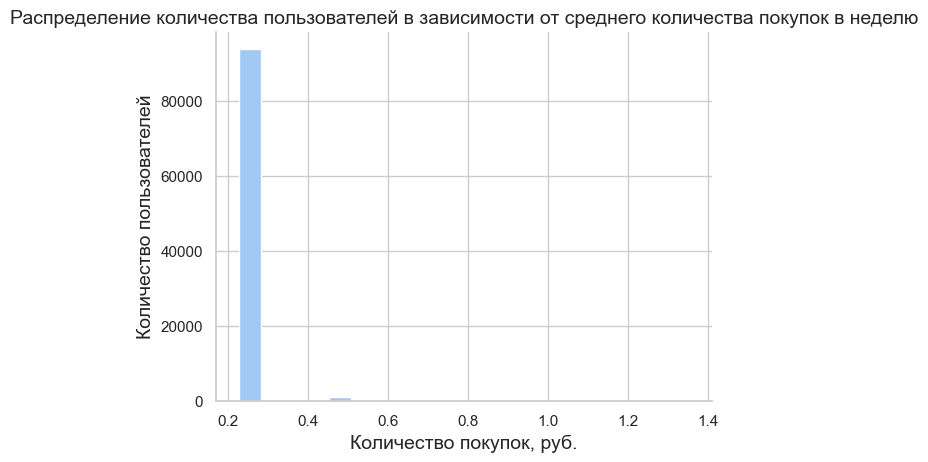

In [530]:
df_purchases_per_month.average_purch_per_week.hist(bins=20)
plt.title('Распределение количества пользователей в зависимости от среднего количества покупок в неделю', fontsize=14)
plt.xlabel('Количество покупок, руб.', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)
sns.despine()

### 3. Когортный анализ пользователей <a name ="Когортный анализ пользователей"></a>

В период с января по декабрь выявим когорту с самым высоким retention на 3-й месяц. 
Посчитаем заказы, сделанные когортами в третий месяц после первого заказа, и найдем когорту с наибольшим количеством таких заказов. Здесь мы будем считать именно все заказы, а не то, что мы относим к покупкам.

Будем работать с df_customers_orders (детализация по товарам нам не пригодится).

Рассчитаем коэффициент удержания пользователей (retention rate) для пользователей, дата первого заказа которых была в 2017 году. В 2016 году было совершено всего лишь 267 покупок, его мы анализировать не будем. 
2018 год также представлен не полностью, поэтому по нему когорты формировать не будем.

Когортами будем считать людей, сделавших первый заказ в тот или иной месяц.   
Метрика для отслеживания — количество заказов.

Добавим данные о дате первой покупке по каждому покупателю.

In [531]:
df_customers_orders['first_order'] = df_customers_orders.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min')
df_customers_orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,month,year,weekday,order_purchase_timestamp_YMD,days_in_month,weeks_in_month,delivery_status,waiting_time,waiting_time_int,first_order
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,10,2017,Monday,2017-10-02,31.0,4.43,delivered,15 days 13:03:27,10-30days,2017-09-04 11:26:38
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,7,2018,Tuesday,2018-07-24,31.0,4.43,delivered,19 days 03:18:23,10-30days,2018-07-24 20:41:37


 Убедимся, что даты заказов рассчитались корректно, проверив случайного пользователя.

In [532]:
df_customers_orders[df_customers_orders.customer_unique_id == 'a239b8e2fbce33780f1f1912e2ee5275']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,month,year,weekday,order_purchase_timestamp_YMD,days_in_month,weeks_in_month,delivery_status,waiting_time,waiting_time_int,first_order
51507,033a79557b0d234035b38da3be948574,c4d145f0b58cc33b0c5a5a21e2ee6c4e,delivered,2017-02-06 14:56:20,2017-02-06 15:05:24,2017-02-07 10:49:58,2017-02-17 18:17:51,2017-03-27,a239b8e2fbce33780f1f1912e2ee5275,69054,...,2,2017,Monday,2017-02-06,28.0,4.0,delivered,48 days 09:03:40,30-50days,2017-02-06 14:56:20
57777,3ee8494bb94ea023beadcd0783c9d8d7,9cd516c73a329f061611ae45ecbbe580,delivered,2017-02-06 14:56:21,2017-02-06 15:05:27,2017-02-14 10:28:00,2017-02-20 19:37:51,2017-03-27,a239b8e2fbce33780f1f1912e2ee5275,69054,...,2,2017,Monday,2017-02-06,28.0,4.0,delivered,48 days 09:03:39,30-50days,2017-02-06 14:56:20
61921,87f41ac2bb62582fa23ddb02b79ef724,fe15b3297ddaaa9458ae5489b2bd8791,delivered,2017-02-17 15:15:26,2017-02-17 15:25:08,2017-02-20 11:00:07,2017-03-16 17:16:26,2017-03-30,a239b8e2fbce33780f1f1912e2ee5275,69054,...,2,2017,Friday,2017-02-17,28.0,4.0,delivered,40 days 08:44:34,30-50days,2017-02-06 14:56:20
67584,1972a123466d40a62224630f7d0de530,0f41a66a477328c778e98eacb6a6867b,delivered,2017-02-06 17:06:53,2017-02-06 17:22:07,2017-02-13 14:53:42,2017-02-17 21:37:42,2017-03-27,a239b8e2fbce33780f1f1912e2ee5275,69054,...,2,2017,Monday,2017-02-06,28.0,4.0,delivered,48 days 06:53:07,30-50days,2017-02-06 14:56:20


Сформируем таблицу для расчета когорт, оставив только пользователей с первой покупкой в 2017 году.

In [533]:
df_cohort = df_customers_orders[['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'first_order']].query('first_order.dt.year==2017')
df_cohort.head()

,customer_unique_id,order_id,order_purchase_timestamp,first_order
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-09-04 11:26:38
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11-18 19:28:06
5,80bb27c7c16e8f973207a5086ab329e2,a4591c265e18cb1dcee52889e2d8acc3,2017-07-09 21:57:05,2017-07-09 21:57:05
6,36edbb3fb164b1f16485364b6fb04c73,136cce7faa42fdb2cefd53fdc79a6098,2017-04-11 12:22:08,2017-04-11 12:22:08
7,932afa1e708222e5821dac9cd5db4cae,6514b8ad8028c9f2cc2374ded245783f,2017-05-16 13:10:30,2017-05-16 13:10:30


Добавим столбец с месяцем первой покупки, который и станет индикатором когорты.

In [534]:
df_cohort['cohort_month'] = df_cohort['first_order'].dt.strftime('%Y-%m')
df_cohort['order_month'] = df_cohort['order_purchase_timestamp'].dt.strftime('%Y-%m')


df_cohort['cohort_month'] = pd.to_datetime(df_cohort['cohort_month'])
df_cohort['order_month'] = pd.to_datetime(df_cohort['order_month'])

In [535]:
df_cohort.head(2)

,customer_unique_id,order_id,order_purchase_timestamp,first_order,cohort_month,order_month
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-09-04 11:26:38,2017-09-01,2017-10-01
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11-18 19:28:06,2017-11-01,2017-11-01


Сформируем когорты по месяцу покупки, рассчитав, сколько пользователей в каждой когорте и сколько заказов они сделали за промежуток времени по предоставленным данным. Мы видим, что количество новых пользователей в целом растет с января и достигает своего максимума в ноябре, далее в декабре количество пользователей снижается.  

Выясним, как изменяется количество покупающих пользователей внутри одной когорты, чтобы понять, сколько людей продолжают покупать в следующих месяцах после совершения первой покупки. Мы видим, что количество покупателей в каждой из когорт после первого месяца снижается, что логично, так как 97% клиентов делают только 1 покупку.

In [536]:
df_cohort_pivot = df_cohort.pivot_table(
    index  ='cohort_month',
    columns='order_month',
    values ='customer_unique_id',
    aggfunc='nunique'
                         )

df_cohort_pivot

order_month,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01
cohort_month,,,,,,,,,,,,,,,,,,,,
2017-01-01,764.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,3.0,1.0,6.0,3.0,1.0,1.0,2.0,3.0,NaN,1.0
2017-02-01,NaN,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0,NaN
2017-03-01,NaN,NaN,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,4.0,6.0,3.0,4.0,6.0,2.0,4.0
2017-04-01,NaN,NaN,NaN,2352.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,5.0
2017-05-01,NaN,NaN,NaN,NaN,3596.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,11.0,9.0,12.0,9.0,1.0,7.0,9.0
2017-06-01,NaN,NaN,NaN,NaN,NaN,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,6.0
2017-07-01,NaN,NaN,NaN,NaN,NaN,NaN,3894.0,20.0,14.0,10.0,11.0,8.0,12.0,4.0,7.0,10.0,9.0,12.0,5.0,10.0
2017-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4184.0,29.0,14.0,11.0,15.0,22.0,12.0,11.0,6.0,6.0,10.0,8.0,4.0
2017-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4130.0,28.0,22.0,12.0,19.0,9.0,9.0,10.0,12.0,7.0,11.0,3.0


Чтобы понять, что произошло на третий месяц жизни каждой когорты, найдём метрику lifetime когорты.
Из месяца совершения заказа order_month вычтем месяц когорты cohort_month.

In [537]:
df_cohort['cohort_lifetime'] = df_cohort['order_month'] - df_cohort['cohort_month']
df_cohort.head(2)

,customer_unique_id,order_id,order_purchase_timestamp,first_order,cohort_month,order_month,cohort_lifetime
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-09-04 11:26:38,2017-09-01,2017-10-01,30 days
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11-18 19:28:06,2017-11-01,2017-11-01,0 days


Проверим тип получившихся данных.

In [538]:
df_cohort.dtypes

customer_unique_id                   object
order_id                             object
order_purchase_timestamp     datetime64[ns]
first_order                  datetime64[ns]
cohort_month                 datetime64[ns]
order_month                  datetime64[ns]
cohort_lifetime             timedelta64[ns]
dtype: object

Представим cohort_lifetime в виде месяцев, разделив на среднюю длину месяца в году.
Также снова представим cohort_month в формате str, извелечем только месяц покупки.

In [539]:
df_cohort['cohort_lifetime'] = df_cohort['cohort_lifetime']/np.timedelta64(1, 'M')
df_cohort['cohort_lifetime'] = df_cohort['cohort_lifetime'].round().astype('int')
df_cohort['cohort_month']    = df_cohort['cohort_month'].dt.month

In [540]:
df_cohort.head(2)

,customer_unique_id,order_id,order_purchase_timestamp,first_order,cohort_month,order_month,cohort_lifetime
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-09-04 11:26:38,9,2017-10-01,1
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11-18 19:28:06,11,2017-11-01,0


In [541]:
df_cohort_pivot_lifetime = df_cohort.pivot_table(
                                    index   = 'cohort_month',
                                    columns = 'cohort_lifetime',
                                    values  = 'customer_unique_id',
                                    aggfunc = 'nunique')
df_cohort_pivot_lifetime

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
cohort_month,,,,,,,,,,,,,,,,,,,
1,764.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,3.0,1.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0
2,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0,NaN
3,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,4.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN
4,2352.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,5.0,NaN,NaN
5,3596.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,11.0,9.0,12.0,9.0,1.0,7.0,9.0,NaN,NaN,NaN
6,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN
7,3894.0,20.0,14.0,10.0,11.0,8.0,12.0,4.0,7.0,10.0,9.0,12.0,5.0,10.0,NaN,NaN,NaN,NaN,NaN
8,4184.0,29.0,14.0,11.0,15.0,22.0,12.0,11.0,6.0,6.0,10.0,8.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
9,4130.0,28.0,22.0,12.0,19.0,9.0,9.0,10.0,12.0,7.0,11.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Построим тепловую карту.

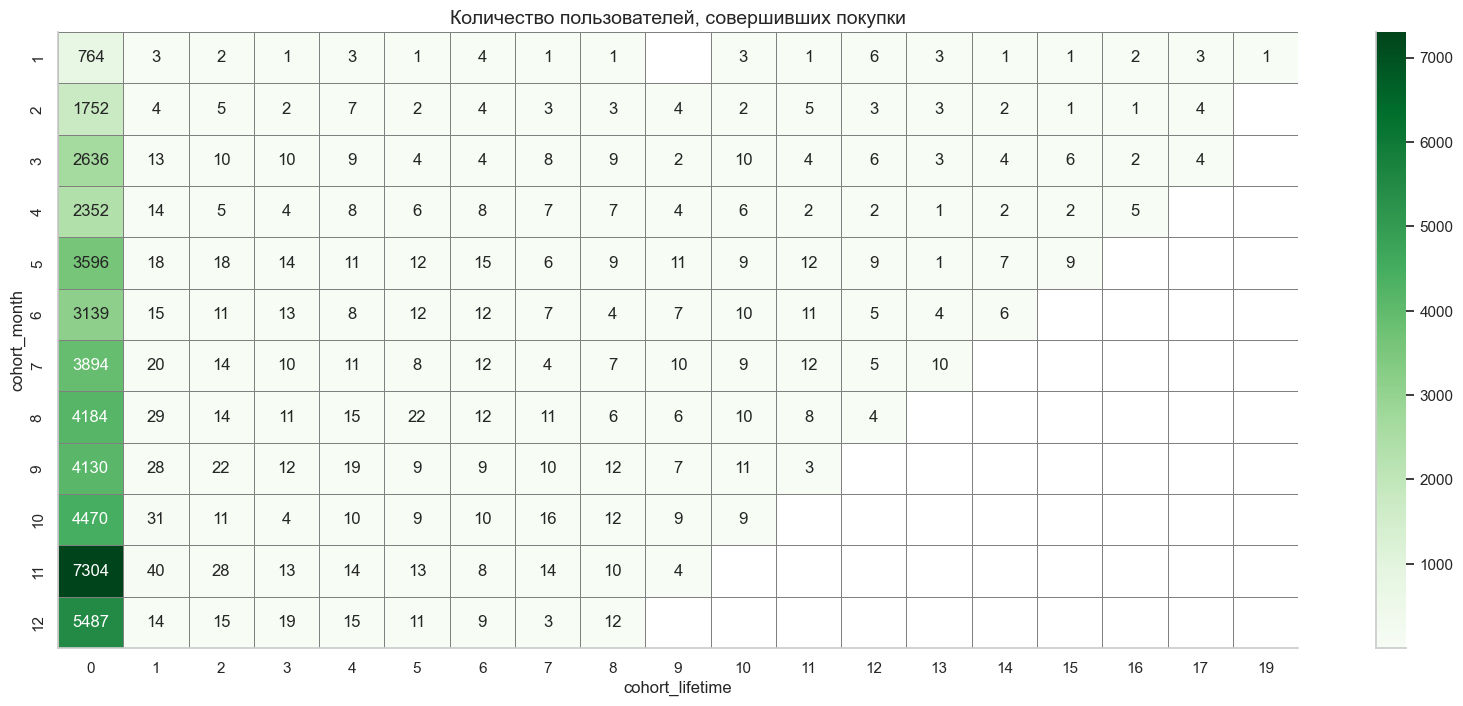

In [542]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(df_cohort_pivot_lifetime, annot=True, fmt='.0f', linewidths=0.5, linecolor='gray', cmap="Greens")
plt.title('Количество пользователей, совершивших покупки', fontsize = 14)

sns.despine()

Retention Rate = число пользователей в каждую следующую неделю/ число пользователей, изначально бывших в когорте.

Найдем исходное количество пользователей в каждой когорте.

In [543]:
cohort_grouped_initial = df_cohort.groupby('cohort_month', as_index=False).agg({'customer_unique_id': 'nunique'})
cohort_grouped_initial = cohort_grouped_initial.rename(columns = {'customer_unique_id': 'initial_number'})
cohort_grouped_initial

,cohort_month,initial_number
0,1,764
1,2,1752
2,3,2636
3,4,2352
4,5,3596
5,6,3139
6,7,3894
7,8,4184
8,9,4130
9,10,4470


Разобьем данные о количестве пользователей в каждой когорте по месяцам.

In [544]:
cohort_grouped = df_cohort.groupby(['cohort_month', 'cohort_lifetime'], as_index=False)\
                          .agg({'customer_unique_id': 'nunique'})\
                          .rename(columns = {'customer_unique_id': 'number_per_month'})
cohort_grouped

,cohort_month,cohort_lifetime,number_per_month
0,1,0,764
1,1,1,3
2,1,2,2
3,1,3,1
4,1,4,3
...,...,...,...
166,12,4,15
167,12,5,11
168,12,6,9
169,12,7,3


Объединим данные по когортам с исходным количеством пользователей в когорте и рассчитаем retention rate.

In [545]:
df_retention              = cohort_grouped.merge(cohort_grouped_initial, on = 'cohort_month', how = 'left')
df_retention['retention'] = df_retention['number_per_month']/df_retention['initial_number'].round(2)
df_retention

,cohort_month,cohort_lifetime,number_per_month,initial_number,retention
0,1,0,764,764,1.000000
1,1,1,3,764,0.003927
2,1,2,2,764,0.002618
3,1,3,1,764,0.001309
4,1,4,3,764,0.003927
...,...,...,...,...,...
166,12,4,15,5487,0.002734
167,12,5,11,5487,0.002005
168,12,6,9,5487,0.001640
169,12,7,3,5487,0.000547


Максимальный показатель CR составил 0.78%.

In [546]:
df_retention[df_retention.cohort_lifetime != 0].retention.max()*100

0.7853403141361256

Построим сводную таблицу на основании полученных данных.

In [547]:
df_retention_pivot = df_retention.pivot_table(
                        index   = 'cohort_month',
                        columns = 'cohort_lifetime',
                        values  = 'retention')
df_retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
cohort_month,,,,,,,,,,,,,,,,,,,
1,1.0,0.003927,0.002618,0.001309,0.003927,0.001309,0.005236,0.001309,0.001309,NaN,0.003927,0.001309,0.007853,0.003927,0.001309,0.001309,0.002618,0.003927,0.001309
2,1.0,0.002283,0.002854,0.001142,0.003995,0.001142,0.002283,0.001712,0.001712,0.002283,0.001142,0.002854,0.001712,0.001712,0.001142,0.000571,0.000571,0.002283,NaN
3,1.0,0.004932,0.003794,0.003794,0.003414,0.001517,0.001517,0.003035,0.003414,0.000759,0.003794,0.001517,0.002276,0.001138,0.001517,0.002276,0.000759,0.001517,NaN
4,1.0,0.005952,0.002126,0.001701,0.003401,0.002551,0.003401,0.002976,0.002976,0.001701,0.002551,0.000850,0.000850,0.000425,0.000850,0.000850,0.002126,NaN,NaN
5,1.0,0.005006,0.005006,0.003893,0.003059,0.003337,0.004171,0.001669,0.002503,0.003059,0.002503,0.003337,0.002503,0.000278,0.001947,0.002503,NaN,NaN,NaN
6,1.0,0.004779,0.003504,0.004141,0.002549,0.003823,0.003823,0.002230,0.001274,0.002230,0.003186,0.003504,0.001593,0.001274,0.001911,NaN,NaN,NaN,NaN
7,1.0,0.005136,0.003595,0.002568,0.002825,0.002054,0.003082,0.001027,0.001798,0.002568,0.002311,0.003082,0.001284,0.002568,NaN,NaN,NaN,NaN,NaN
8,1.0,0.006931,0.003346,0.002629,0.003585,0.005258,0.002868,0.002629,0.001434,0.001434,0.002390,0.001912,0.000956,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,0.006780,0.005327,0.002906,0.004600,0.002179,0.002179,0.002421,0.002906,0.001695,0.002663,0.000726,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Построим тепловую карту.

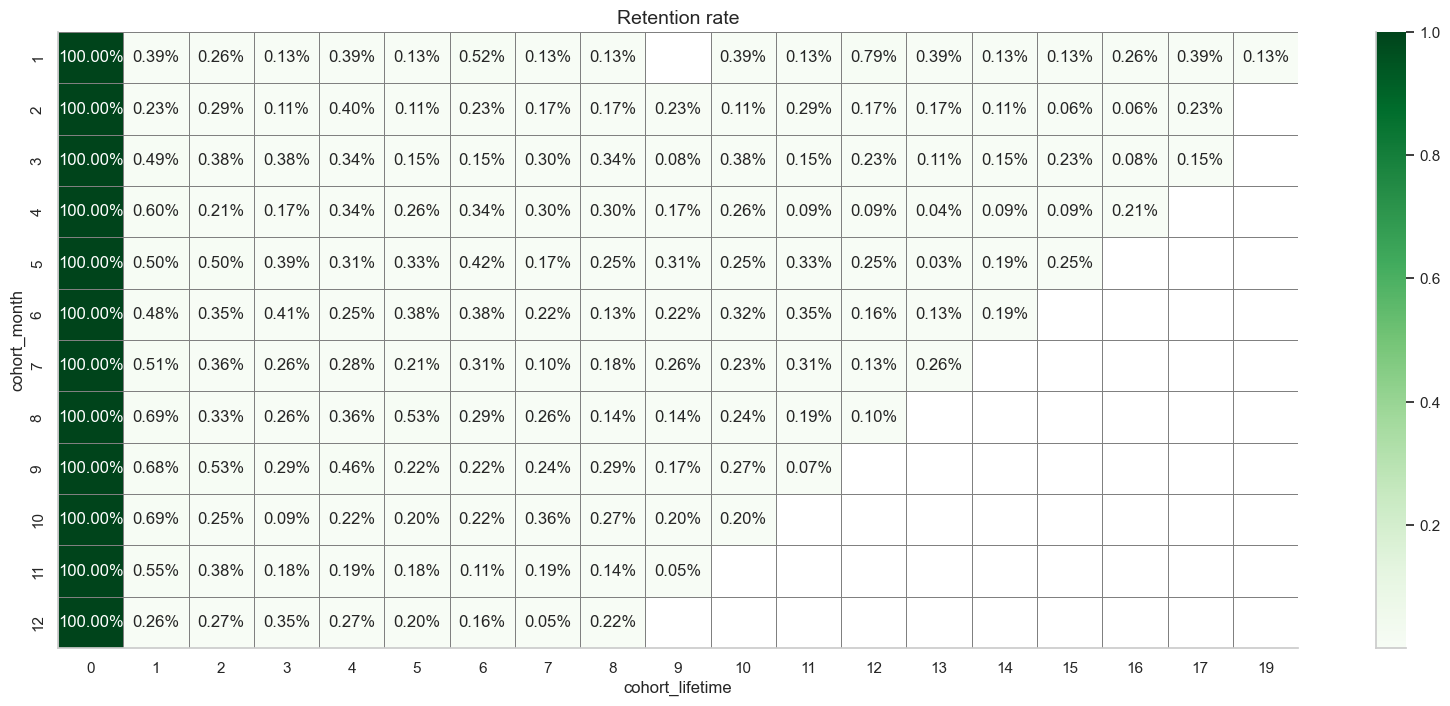

In [548]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(df_retention_pivot, annot=True, fmt = '.2%', linewidths=0.5, linecolor='gray', cmap="Greens")
plt.title('Retention rate', fontsize=14)
sns.despine()

plt.show()

Проанализируем полученные показатели retention rate.
Самый высокий retention rate на 3-й месяц составляет 0.41% и относится к покупателям, оформившим первый заказ в июне. 

In [549]:
df_retention[df_retention['cohort_lifetime'] == 3]['retention'].max()

0.00414144632048423

В целом cамый высокий retention rate составил 0.7%, показали его в декабре пользователи, пришедшие в июне.  

In [550]:
df_retention[df_retention['cohort_lifetime']!= 0]['retention'].max()

0.007853403141361256

In [551]:
df_retention[df_retention['retention']==0.007853403141361256]

,cohort_month,cohort_lifetime,number_per_month,initial_number,retention
11,1,12,6,764,0.007853


Посмотрим, какие когорты прибыльнее, просуммировав данные о стоимости товара в столбце price. Для этого сформируем датафрейм с данными о когортах и товарах.

In [552]:
df_cohort_revenue = df_cohort.merge(df_order_items, on = 'order_id', how = 'left')

df_cohort_revenue = df_cohort_revenue.groupby('cohort_month', as_index=False)\
                                     .agg({'price': 'sum'})\
                                     .rename(columns = {'price': 'revenue'})
                 
df_cohort_revenue = df_cohort_revenue.merge(cohort_grouped_initial, on = 'cohort_month')\
                                     .sort_values('revenue', ascending = False)

#Рассчитаем долю каждой когорты в общей сумме для каждого показателя

total_revenue        = df_cohort_revenue['revenue'].sum()
total_initial_number = df_cohort_revenue['initial_number'].sum()

df_cohort_revenue['revenue_share']        = (df_cohort_revenue['revenue'] / total_revenue).round(2)*100
df_cohort_revenue['initial_number_share'] = (df_cohort_revenue['initial_number'] / total_initial_number).round(2)*100

df_cohort_revenue

,cohort_month,revenue,initial_number,revenue_share,initial_number_share
10,11,1014855.02,7304,16.0,17.0
11,12,740781.54,5487,12.0,13.0
9,10,667834.76,4470,11.0,10.0
8,9,630280.01,4130,10.0,9.0
7,8,585037.04,4184,9.0,10.0
4,5,520432.50,3596,8.0,8.0
6,7,505829.27,3894,8.0,9.0
5,6,447194.54,3139,7.0,7.0
2,3,387443.32,2636,6.0,6.0
3,4,371777.53,2352,6.0,5.0


В целом, мы видим, что самой прибыльной является когорта 11-го месяца, она же является и самой многочисленной. Выручка по когортам кореллирует с количеством покупателей.

#### 4. RFM-сегментация пользователей <a name ="RFM-сегментация пользователей"></a>

 Построим RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.   
 R - время от последней покупки пользователя до текущей даты,  
 F - суммарное количество покупок у пользователя за всё время,   
 M - сумма покупок за всё время. 

Для анализа возьмем датасет df_purchases и добавим к нему данные о товарах, их ценах и количестве.

In [553]:
df_rfm = df_purchases.merge(df_order_items,how='left', on='order_id')

Проверим, что все корректно сформировалось, количество заказов осталось прежним.

In [554]:
df_purchases.order_id.nunique()

96456

In [555]:
df_rfm.order_id.nunique()

96456

In [556]:
df_rfm.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,weekday,order_purchase_timestamp_YMD,days_in_month,weeks_in_month,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,Monday,2017-10-02,31.0,4.43,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,Tuesday,2018-07-24,31.0,4.43,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,Wednesday,2018-08-08,31.0,4.43,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,Saturday,2017-11-18,30.0,4.29,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,Tuesday,2018-02-13,28.0,4.00,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [557]:
print('Заказы с {} по {}.'.format(df_rfm['order_approved_at'].min(),  
                                    df_rfm['order_approved_at'].max()))

print('Длительность анализируемого периода - {}.'.format(df_rfm['order_approved_at'].min()-df_rfm['order_approved_at'].max()))

Заказы с 2016-09-15 12:16:38 по 2018-08-29 15:10:26.
Длительность анализируемого периода - -714 days +21:06:12.


Предположим,что текущая дата - это следующий день после последней покупки, т.е. 2018-08-30.
Создадим новую переменную now.

In [558]:
now = df_rfm['order_approved_at'].max() + timedelta(days=1)
now

Timestamp('2018-08-30 15:10:26')

В анализе мы будем использовать все имеющиеся у нас данные, период задавать не будем.   
Для расчета R (recency) найдем количество дней, прошедших с момента последнего заказа для каждого покупателя.

In [559]:
df_rfm['days_since_order'] = df_rfm['order_purchase_timestamp'].apply(lambda x: (now - x).days)

In [560]:
df_rfm.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,order_purchase_timestamp_YMD,days_in_month,weeks_in_month,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,days_since_order
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,2017-10-02,31.0,4.43,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,332
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,2018-07-24,31.0,4.43,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,36


In [561]:
recency = df_rfm.groupby('customer_unique_id')\
                .agg({'days_since_order': 'min'})\
                .rename(columns = {'days_since_order': 'recency'})
recency.head()

,recency
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,112
0000b849f77a49e4a4ce2b2a4ca5be3f,115
0000f46a3911fa3c0805444483337064,537
0000f6ccb0745a6a4b88665a16c9f078,321
0004aac84e0df4da2b147fca70cf8255,288


In [562]:
recency.describe(percentiles =[.2, .4, .6, .8])

,recency
count,93337.000000
mean,237.915521
std,152.552840
min,1.000000
20%,92.000000
40%,177.000000
50%,219.000000
60%,268.000000
80%,382.000000
max,714.000000


Для расчета F (frequency) найдем общее количество заказов у пользователя за всё время

In [563]:
frequency = df_rfm.groupby('customer_unique_id')\
                  .agg({'order_id': 'nunique'})\
                  .rename(columns = {'order_id': 'frequency'})\
                  .sort_values('frequency', ascending=False)

frequency.head()

,frequency
customer_unique_id,
8d50f5eadf50201ccdcedfb9e2ac8455,15
3e43e6105506432c953e165fb2acf44c,9
1b6c7548a2a1f9037c1fd3ddfed95f33,7
6469f99c1f9dfae7733b25662e7f1782,7
ca77025e7201e3b30c44b472ff346268,7


In [564]:
frequency.describe(percentiles = [.2, .4, .6, .8])

,frequency
count,93337.000000
mean,1.033417
std,0.209096
min,1.000000
20%,1.000000
40%,1.000000
50%,1.000000
60%,1.000000
80%,1.000000
max,15.000000


M - сумма покупок за всё время (выручка по каждому покупателю).   
Разобьем покупателей на группы в зависимости от стоимости товаров.

In [565]:
monetary = df_rfm.groupby('customer_unique_id')\
.agg({'price': 'sum'})\
.rename(columns = {'price': 'monetary'})

monetary.head()

,monetary
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
0000f46a3911fa3c0805444483337064,69.00
0000f6ccb0745a6a4b88665a16c9f078,25.99
0004aac84e0df4da2b147fca70cf8255,180.00


In [566]:
monetary.describe(percentiles = [.2, .4, .6, .8])

,monetary
count,93337.000000
mean,141.622063
std,215.713022
min,0.850000
20%,39.900000
40%,69.900000
50%,89.700000
60%,109.900000
80%,179.900000
max,13440.000000


Сформируем общий датафрейм для rfm анализа.

In [567]:
rfm_analysis = recency.merge(frequency, on='customer_unique_id').merge(monetary, on='customer_unique_id')
rfm_analysis

,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
0000f46a3911fa3c0805444483337064,537,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
0004aac84e0df4da2b147fca70cf8255,288,1,180.00
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,447,1,1570.00
fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89
ffff371b4d645b6ecea244b27531430a,568,1,89.90


Проранжируем RM показатели, используя квинтили (20%), разбив их на группы.

In [568]:
quintiles_r = rfm_analysis[['recency']].quantile([.1, .6]).to_dict()
quintiles_r

{'recency': {0.1: 42.0, 0.6: 268.0}}

In [569]:
quintiles_m = rfm_analysis[['monetary']].quantile([.33, .66]).to_dict()
quintiles_m

{'monetary': {0.33: 57.9, 0.66: 124.9}}

F показатель мы разобьем на 2 группы, так как (как мы уже выяснили) бОльшая часть покупателей совершает не более одной покупки.
Зададим пороги вручную: 
- пользователи, совершившие 1 покупку,
- пользователи, совершившие 2 и более покупок.

Чем ниже показатель recency, тем выше будет ранг покупателя.

In [570]:
def r_score(x):
    if x <= quintiles_r['recency'][.1]:
        return 3
    elif x <= quintiles_r['recency'][.6]:
        return 2
    else:
        return 1

Наоборот, чем ниже показатель monetary, тем ниже будет ранг покупателя.

In [571]:
def m_score(x):
    if x <= quintiles_m['monetary'][.33]:
        return 1
    elif x <= quintiles_m['monetary'][.66]:
        return 2
    else:
        return 3

Чем выше показатель frequency, тем выше будет ранг покупателя.
Пользователей с количеством покупок 2 и более выделим в отдельный rfm сегмент.

In [572]:
def f_score(x):
    if x <= 1:
        return 1
    elif x >= 2:
        return 2
    

Найдем показатели RFM для каждого покупателя

In [573]:
rfm_analysis['R'] = rfm_analysis['recency'].apply(lambda x: r_score(x))
rfm_analysis['F'] = rfm_analysis['frequency'].apply(lambda x: f_score(x))
rfm_analysis['M'] = rfm_analysis['monetary'].apply(lambda x: m_score(x))

In [574]:
rfm_analysis = rfm_analysis.reset_index() 
rfm_analysis

,customer_unique_id,recency,frequency,monetary,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,2,1,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,2,1,1
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1,1
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,1,1,3
...,...,...,...,...,...,...,...
93332,fffcf5a5ff07b0908bd4e2dbc735a684,447,1,1570.00,1,1,3
93333,fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89,2,1,2
93334,ffff371b4d645b6ecea244b27531430a,568,1,89.90,1,1,2
93335,ffff5962728ec6157033ef9805bacc48,119,1,115.00,2,1,2


Найдем общий показатель RFM для каждого покупателя

In [575]:
rfm_analysis['RFM_score'] = rfm_analysis['R'].map(str) + rfm_analysis['F'].map(str) + rfm_analysis['M'].map(str)
rfm_analysis.head(2)

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.9,2,1,3,213
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.9,2,1,1,211


In [576]:
rfm_analysis.groupby('RFM_score', as_index=False).agg({'customer_unique_id': 'count'})

,RFM_score,customer_unique_id
0,111,12193
1,112,12277
2,113,11746
3,121,83
4,122,253
5,123,653
6,211,15234
7,212,14893
8,213,14994
9,221,83


Основываясь на показателях RFM, выделим сегменты и распределим покупателей.

In [577]:
segt_map = {
     r'[1][1-2][1-3]': 'lost customers',
     r'[2][1][1-3]': 'about to sleep - 1 purchase',
     r'[2][2][1-2]': 'loyal - about to sleep - mass',
     r'[2][2][3]': 'loyal - about to sleep - premium',
     r'[3][1][1-2]': 'new - mass',
     r'[3][1][3]': 'new - premium',
     r'[3][2][1-3]': 'loyal'
    }

rfm_analysis['segment'] = rfm_analysis['R'].map(str) + rfm_analysis['F'].map(str) + rfm_analysis['M'].map(str)
rfm_analysis['segment'] = rfm_analysis['segment'].replace(segt_map, regex=True)
rfm_analysis.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,2,1,3,213,about to sleep - 1 purchase
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,2,1,1,211,about to sleep - 1 purchase
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112,lost customers
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1,1,111,lost customers
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,1,1,3,113,lost customers


| Сегмент                                | Описание                                                                         |
|----------------------------------------|----------------------------------------------------------------------------------|
| loyal                                  | Совершили несколько покупок около месяца назад                                   | 
| new - premium                          | Совершили 1 покупку около месяца назад, товар по высокой цене                    |
| new - mass                             | Совершили покупку около месяца назад, товар по низкой и средней цене             |
| loyal - about to sleep - premium       | Совершили 2 и более покупок более 1 месяца назад,товар по высокой цене           |
| loyal - about to sleep - mass          | Совершили 2 и более покупок более 1 месяца назад,товар по средней и высокой цене |
| about to sleep - 1 purchase            | Совершили 1 покупку более 1 месяца назад, возможно не вернутся                   |
| lost customers                         | Совершили покупку более 9 месяцев назад, не вернутся                             |


Рассчитаем средние значения для каждого уровня RFM.

In [579]:
rfm_analysis_agg = rfm_analysis.groupby('segment')\
                                .agg({'recency': 'mean',
                                       'frequency': 'mean',
                                       'monetary': ['mean', 'count']
                                     }).round(1)

print(rfm_analysis_agg)

                                 recency frequency monetary       
                                    mean      mean     mean  count
segment                                                           
about to sleep - 1 purchase        156.4       1.0    137.1  45121
lost customers                     394.9       1.0    142.5  37205
loyal                               24.2       2.2    270.8    309
loyal - about to sleep - mass      152.7       2.0     84.1    413
loyal - about to sleep - premium   154.5       2.2    336.1   1089
new - mass                          23.3       1.0     60.4   6220
new - premium                       24.4       1.0    292.2   2980


### Визуализация

Визуализируем полученные данные по сегментам покупателей.
Посмотрим на распределение количества покупателей в рамках показателей, а также в границах сегментов.

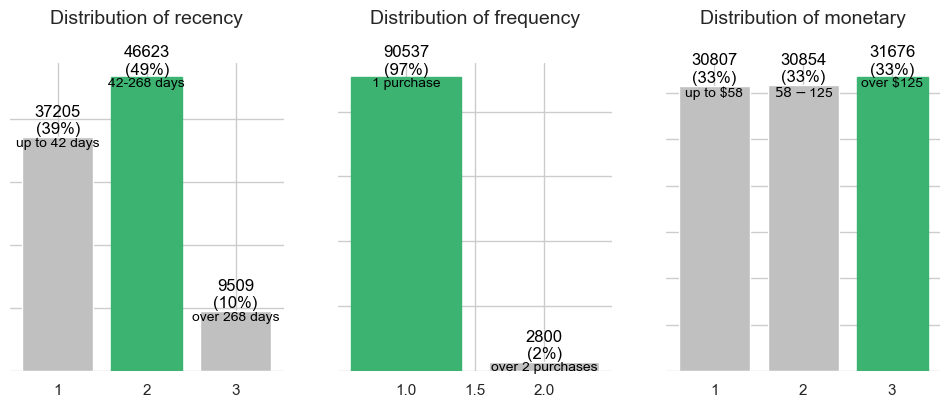

In [580]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

rfm_characteristics = {
    'R': ['up to 42 days', '42-268 days', 'over 268 days'],
    'F': ['1 purchase', 'over 2 purchases'],
    'M': ['up to $58', '$58-$125', 'over $125'],
}

for i, p in enumerate(['R', 'F', 'M']):
        parameters = {'R': 'recency', 'F': 'frequency', 'M': 'monetary'}
        y = rfm_analysis[p].value_counts().sort_index()
        x = y.index
        ax = axes[i]
        bars = ax.bar(x, y, color='silver')
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_title('Distribution of {}'.format(parameters[p]),
                    fontsize=14, y = 1.1)
        for j, bar in enumerate (bars):
            value = bar.get_height()
            if value == y.max():
                bar.set_color('mediumseagreen')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value - 5,
                    '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
                   ha='center',
                   va='bottom',
                   color='black')

     #Добавим характеристики для каждого сегмента RFM       
            ax.text(bar.get_x() + bar.get_width() / 2,
                        value - 50, 
                        rfm_characteristics[p][j],
                        ha='center',
                        va='top',  
                        color='black', fontsize=10) 
   
plt.show()

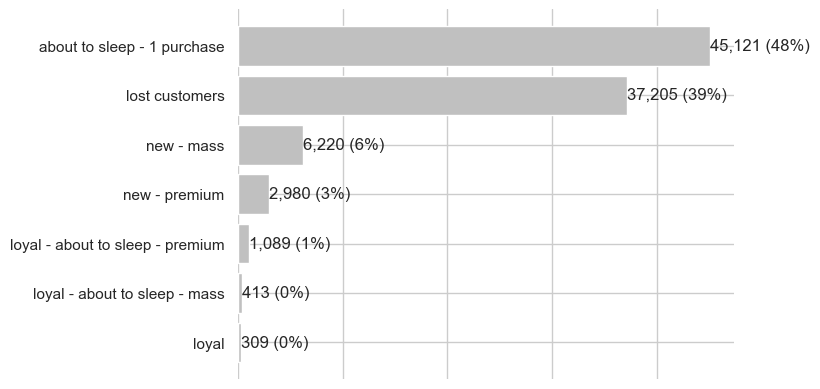

In [581]:
# count the number of customers in each segment
segments_counts = rfm_analysis['segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
         value = bar.get_width()
         ax.text(value,
                 bar.get_y() + bar.get_height()/2,
                 '{:,} ({:}%)'.format(int(value),
                                    int(value*100/segments_counts.sum())),
                 va='center',
                 ha='left'
                )

plt.show()


Таким образом, проведенный RFM анализ позволил нам сделать следующие выводы:
 - 97% покупателей предпочитают совершать единоразовые покупки, соответственно CR очень низкий и составляет менее 1%;
 - несмотря на то, что группа лояльных покупателей очень мала, более подробный анализ поведения лояльных покупателей возможно подскажет, как заинтересовать остальных покупателей совершать повторные покупки;
 - прежде всего, необходимо убедиться, что нет проблем с качеством товара, с системой оформления заказа, добавления в корзину;
 - если проблемы есть - необходимо точечно их проработать, возможно ввести службу поддержки покупателей;
 - далее, если проблем выявлено не будет, можно провести опрос среди новых покупателей об их удовлетворенности;
 - для новых покупателей возможно предоставить промокод на следующщий заказ в течение месяца;
 - введение программ лояльности для постоянных покупателей (бонусные программы, дисконтная карта, бесплатная доставка и др.);
 - сделать рассылку для пользователей, совершивших покупки более месяца назад с перечислением текущих акций, выгодными предложениями;
 - если позволяет бюджет, возможно внедрение CRM-системы для персонализированного подхода к покупателям и формирования специальных предложений исходя из их поведения.    